An advertising promotion tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier 
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
# load in the data
train_data = pd.read_csv('../data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [73]:
# check number of missing values per column
train_data.isnull().mean()

ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

In [74]:
test_data = pd.read_csv('./Test.csv')
test_data.head(7)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2
5,13,Yes,0,0,32.566788,-1.684550,2,1,2,1
6,19,No,0,2,29.833921,-1.078506,1,2,3,2


In [0]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [76]:
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [77]:
train_data['purchase'].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

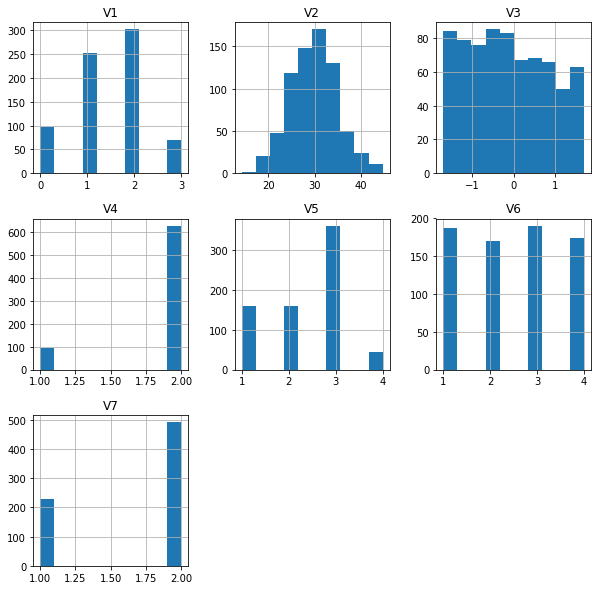

In [78]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

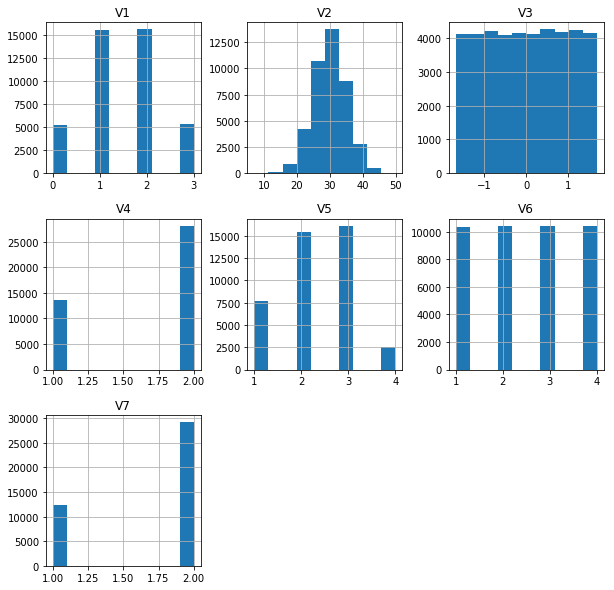

In [79]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==0)][features].hist(figsize=(10,10));

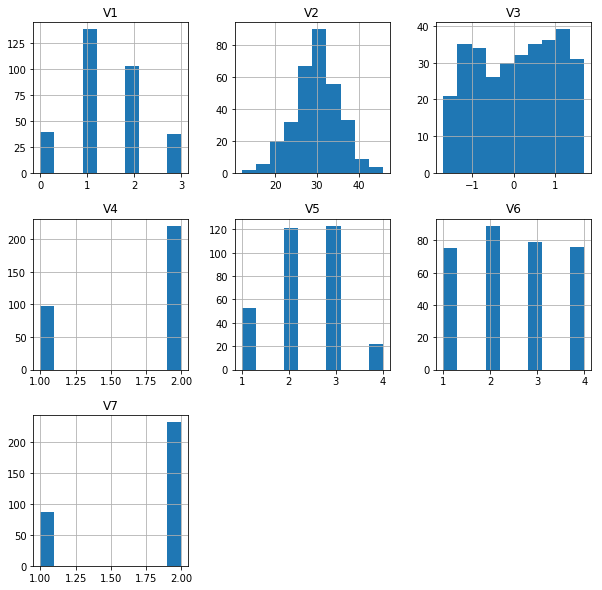

In [80]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

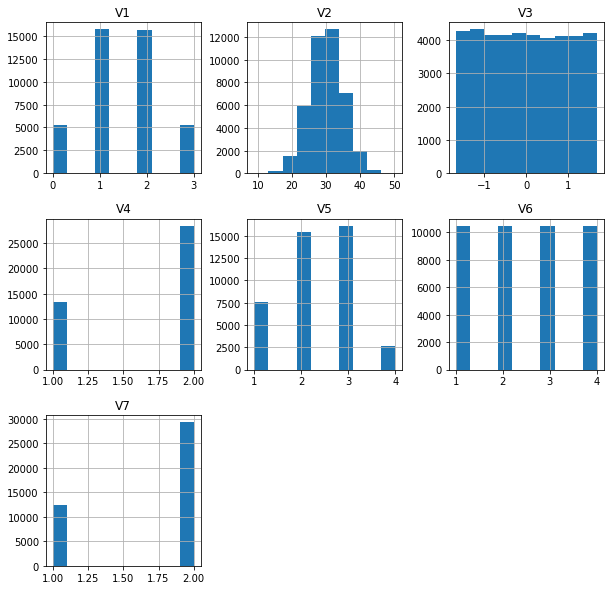

In [81]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==0)][features].hist(figsize=(10,10));

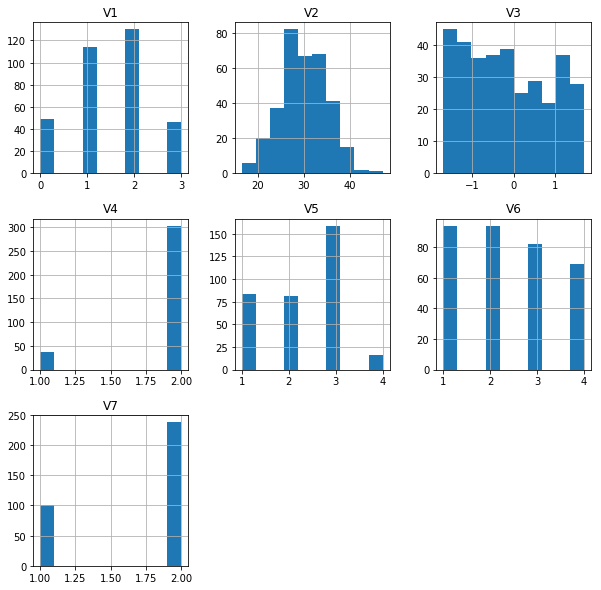

In [82]:
test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==1)][features].hist(figsize=(10,10));

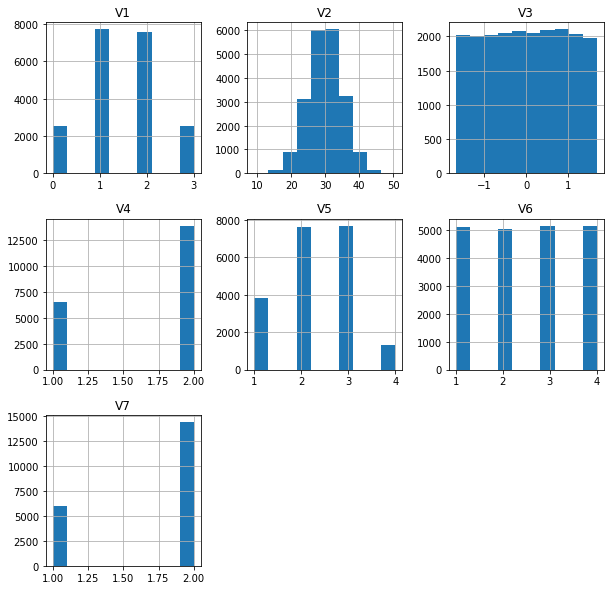

In [83]:
test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==0)][features].hist(figsize=(10,10));

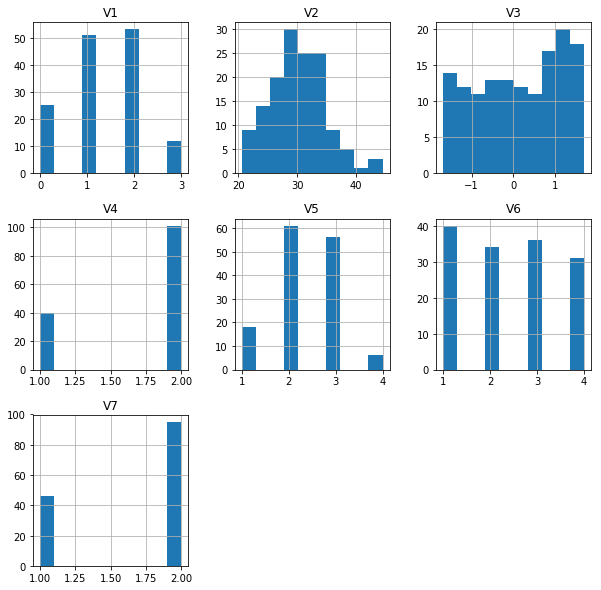

In [84]:
test_data[(test_data['Promotion']=='No') & (test_data['purchase']==1)][features].hist(figsize=(10,10));

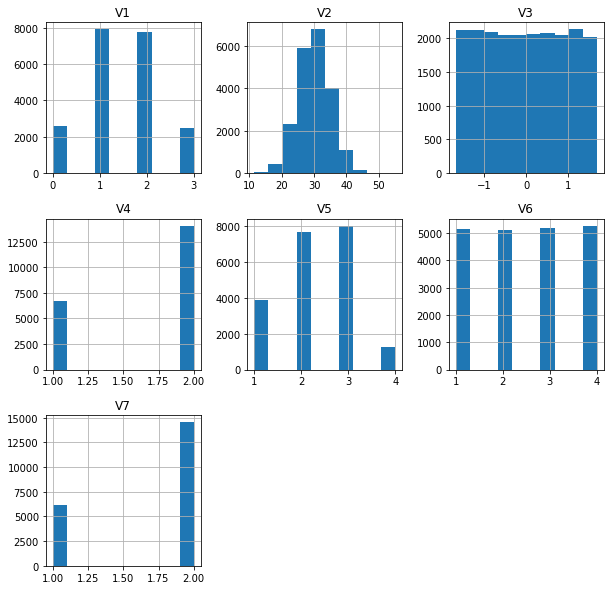

In [85]:
test_data[(test_data['Promotion']=='No') & (test_data['purchase']==0)][features].hist(figsize=(10,10));

In [0]:
# testing baseline model, where we send promotions to everyone

def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [0]:
import pandas as pd
import numpy as np

def score(df, promo_pred_col = 'Promotion'):
    n_treat       = df.loc[df[promo_pred_col] == 'Yes',:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 'No',:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 'No', 'purchase'].sum()
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return (irr, nir)
    

def test_results(promotion_strategy):
    test_data = pd.read_csv('Test.csv')
    df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    
    print('irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('nir with this strategy is {:0.2f}.'.format(nir))
    
    return irr, nir

# added this function to test our irr and nlr on the validation set
def valid_results(promotion_strategy, valid_data):
    df = valid_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    promos = promotion_strategy(df)
    score_df = valid_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    print('irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('nir with this strategy is {:0.2f}.'.format(nir))
    
    return irr, nir

In [88]:
test_results(promotion_strategy)

irr with this strategy is 0.0096.

nir with this strategy is -1132.20.


(0.009593158278250108, -1132.1999999999998)

If we were to send everyone a promotion, our IRR is 0.96\% and NIR is -\\$1,132.20. This will be the baseline model. Hence, blindly sending everyone a promotion is going to lose the company a lot of money.

## Model 1: Predict only for indivduals who received promotions and purchased

In this approach, we will assign labels of 1 to those who received the promotions and made purchases, and labels of 0 to everyone else. 

We want the model to find the individuals who are likely to purchase only after they received a promotion. 

In [0]:
# read data
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [0]:
# generate labels
# only those who made a purchase after receiving a promotion will be assigned a label of 1, 
# while the other individuals will be given a label of 0

response = []

for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train_data['response'] = response

In [91]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0.0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0.0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0.0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0.0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,0.0


In [0]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

In [0]:
# generate features and labels
Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

In [94]:
Y_train.value_counts()

0.0    67047
1.0      580
Name: response, dtype: int64

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
# up sample (minority class? )only the train dataset with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [97]:
Y_train_upsamp.value_counts()

1.0    67047
0.0    67047
dtype: int64

In [0]:
from sklearn.linear_model import LogisticRegression

In [99]:
model = LogisticRegression().fit(X_train_upsamp, Y_train_upsamp)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [100]:
# confusion matrix
valid_pred = model.predict(X_valid)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[ 6617, 10149],
       [   39,   102]])

In [101]:
import sklearn.metrics as me

accuracy = me.accuracy_score( valid_pred,Y_valid)

print (accuracy)

0.39740935707103564


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

In [0]:
model = model.fit(X_train_upsamp, Y_train_upsamp)

In [105]:
# confusion matrix
valid_pred = model.predict(X_valid)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[10660,  6106],
       [   57,    84]])

In [106]:
accuracy = me.accuracy_score( valid_pred,Y_valid)

print (accuracy)

0.6354764298811143


In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [108]:
model = KNeighborsClassifier(n_neighbors = 6, metric = 'minkowski', p = 2).fit(X_train_upsamp, Y_train_upsamp)


# confusion matrix
valid_pred = model.predict(X_valid)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)


array([[15909,   857],
       [  134,     7]])

In [109]:
accuracy = me.accuracy_score( valid_pred,Y_valid)

print (accuracy)

0.9413852250547111


In [110]:
# Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.891992	validation_1-auc:0.645481
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.898054	validation_1-auc:0.653202
[2]	validation_0-auc:0.906917	validation_1-auc:0.65697
[3]	validation_0-auc:0.915775	validation_1-auc:0.658408
[4]	validation_0-auc:0.934996	validation_1-auc:0.655914
[5]	validation_0-auc:0.935649	validation_1-auc:0.651876
[6]	validation_0-auc:0.935016	validation_1-auc:0.654039
[7]	validation_0-auc:0.943776	validation_1-auc:0.655699
[8]	validation_0-auc:0.944752	validation_1-auc:0.650929
[9]	validation_0-auc:0.950239	validation_1-auc:0.648446
[10]	validation_0-auc:0.950787	validation_1-auc:0.648789
[11]	validation_0-auc:0.957777	validation_1-auc:0.648527
[12]	validation_0-auc:0.959635	validation_1-auc:0.645952
[13]	validation_0-auc:0.961191	validation_1-auc:0.644991
[14]	validation_0-auc:0.963264	validation_1-auc:0.644359

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

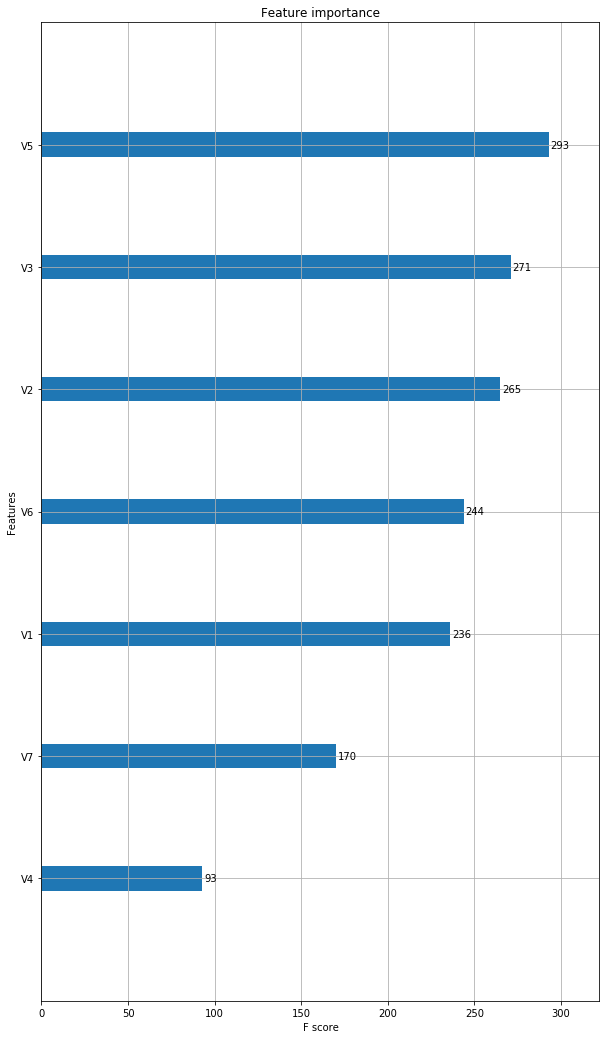

In [111]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [112]:
# confusion matrix
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[12684,  4082],
       [   83,    58]])

In [113]:
accuracy = me.accuracy_score( valid_pred,Y_valid)

print (accuracy)

0.753652333353049


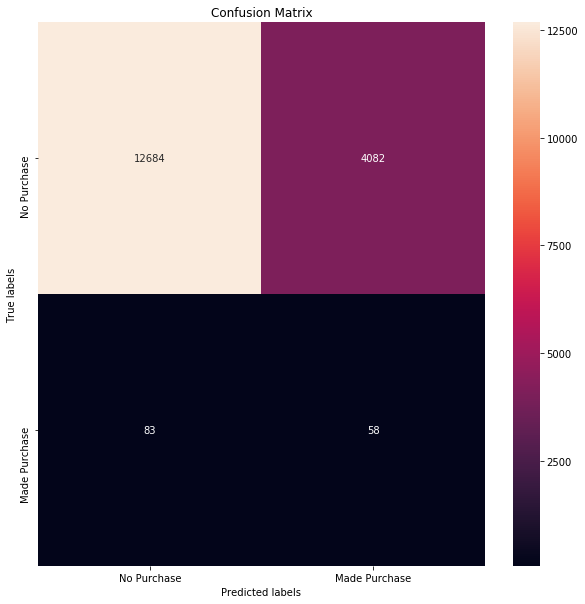

In [114]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [0]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    return promotion

In [116]:
# test irr and nlr on our validation set
valid_results(promotion_strategy, valid)

irr with this strategy is 0.0193.

nir with this strategy is 94.70.


(0.01925125750605293, 94.69999999999999)

In [117]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

irr with this strategy is 0.0219.

nir with this strategy is 332.70.


(0.02185148545762388, 332.70000000000005)